In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
import nltk
import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from gensim.utils import tokenize

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import swifter

In [5]:
import seaborn as sb

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gangu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gangu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gangu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\gangu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Load Data

In [4]:
path_data = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\DATA\\train_data.csv'
path_labels = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\DATA\\train_results.csv'
path_test_data = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\DATA\\test_data.csv'


In [5]:
data_df = pd.read_csv(path_data)
label_df = pd.read_csv(path_labels)
test_df = pd.read_csv(path_test_data)

In [6]:
df = pd.merge(data_df, label_df, on='id')

### Pre-Process data

In [7]:
class PreProc():
    def __init__(self):
        pass
        
    def remove_more_stop_words(self,words_arr):
        if (len(words_arr) > 0):
            remove = np.vectorize(lambda word: self.word_counts[word] >50)
            return words_arr[remove(words_arr)]
        else:
            return ['empty']

    #return low frequency words + words that don't appear in train
    def remove_more_stop_words_test(self,words_arr):
        if (len(words_arr) > 0):
            remove = np.vectorize(lambda word: False if not word in self.word_counts else (True if self.word_counts[word] >50 else False))
            return words_arr[remove(words_arr)]
        else:
            return ['empty']

    #find the correct wordnet tag for nltk pos_tag equivalent  
    def get_wordnet_pos(self,treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN

    #lemmatize 
    def lemmatize(self,word_list):
        pos_tag = nltk.pos_tag(list(word_list))
        words = [self.lemmatizer.lemmatize(i[0], self.get_wordnet_pos(i[1])) for i in pos_tag]
        return words
        
    def preproc(self,df, is_test=False):
    
        feature_df = df.copy()
        #convert lower case
        feature_df['text'] = feature_df['text'].str.lower()
        #remove URLS
        feature_df['text'] = feature_df['text'].str.replace(r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])', '', regex=True)
        #remove mentions
        feature_df['text'] = feature_df['text'].str.replace(r'@([a-zA-Z0-9_]{1,50})', '', regex=True)
        #remove hashtags
        feature_df['text'] = feature_df['text'].str.replace(r'#([a-zA-Z0-9_]{1,50})', '', regex=True)
        #remove punctuations
        feature_df['text'] = feature_df['text'].str.replace(r'[^\w\s]', '', regex=True)
        #tokenize
        feature_df['text'] = feature_df['text'].apply(lambda x : np.asarray(list(tokenize(x))))

        if not is_test:
            #encode target labels 
            label_encoder = LabelEncoder()
            label_encoder.fit(feature_df['target'])
            feature_df['target'] = label_encoder.transform(feature_df['target'])
            #check word counts
            self.word_counts = feature_df.explode('text')['text'].value_counts().to_dict()
            #remove low frequency words
            feature_df['text'] = feature_df['text'].apply(self.remove_more_stop_words)

        elif is_test:
            feature_df['text'] = feature_df['text'].apply(self.remove_more_stop_words_test)

        #lemmatize
        self.lemmatizer = WordNetLemmatizer()
        feature_df['text'] = feature_df['text'].apply(self.lemmatize)

        if not is_test:
            #vocab
            vocabulary = feature_df.explode('text')['text'].value_counts().to_dict()
            #vocab length
            vocab_length = len(vocabulary)
            return feature_df, self.word_counts, vocabulary, vocab_length

        elif is_test:
            return feature_df
            
    

In [ ]:
preprocess = PreProc()
feature_df, word_counts, vocabulary, vocab_length = preprocess.preproc(df, is_test=False)
feature_df_test = preprocess.preproc(test_df, is_test=True)

In [3]:
path_df_NB_train = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\Dataframe\\lemmatized_feature_df_NB.pkl'
path_df_NB_test = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\Dataframe\\lemmatized_feature_df_test_NB.pkl'

In [ ]:
feature_df.to_pickle(path_df_NB_train)
feature_df_test.to_pickle(path_df_NB_test)

In [4]:
#Uncomment and load dataframe if already pro-processed and saved
feature_df = pd.read_pickle(path_df_NB_train)
feature_df_test = pd.read_pickle(path_df_NB_test)

### Create bag of words

In [6]:
def bag_of_words(train_df, test_df):
    feature_df = train_df.copy()
    feature_df['text'] = feature_df['text'].str.join(' ')
    v_c = CountVectorizer(max_features=5000)
    count_transformer = v_c.fit(feature_df['text'])
    x_c = count_transformer.transform(feature_df['text'])
    x_c = x_c.astype('int8')
    x_c = x_c.toarray().astype('int8')
    y = np.asarray(feature_df['target'].tolist())
    
    
    test_df['text'] = test_df['text'].str.join(' ')
    x_c_test = count_transformer.transform(test_df['text'])
    x_c_test = x_c_test.astype('int8')
    x_c_test = x_c_test.todense().astype('int8')
    return x_c, y, x_c_test

In [7]:
x_c, y, x_c_test = bag_of_words(feature_df, feature_df_test)

KeyboardInterrupt: 

### Create train and val for Bag of Words

In [ ]:
x_train_c, x_val_c, y_train_c, y_val_c = train_test_split(x_c, y, test_size=0.20, random_state=40, stratify=y)

### Naive Bayes 

In [13]:
def train_NB(x, y):
    NB_classifier_M = MultinomialNB()
    model_NB_M = NB_classifier_M.fit(x, y)
    path_models_NB = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\Models\\MNB_classifier.pkl'
    with open(path_models_NB, 'wb') as f:
        pickle.dump(model_NB_M, f)
    return model_NB_M

In [14]:
model_NB_M = train_NB(x_train_c, y_train_c)

### Predict on val and metrics

In [15]:
y_pred = model_NB_M.predict(x_val_c)

In [16]:
acc = accuracy_score(y_val_c, y_pred)

In [17]:
cr = classification_report(y_val_c, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.77      0.78      0.77    103961
           1       0.00      0.00      0.00        17
           2       0.78      0.76      0.77    104087

    accuracy                           0.77    208065
   macro avg       0.51      0.51      0.51    208065
weighted avg       0.77      0.77      0.77    208065



In [18]:
cm = confusion_matrix(y_val_c, y_pred)
print(cm)

[[81225    20 22716]
 [    6     0    11]
 [24935    28 79124]]


In [9]:
cm = np.array([[81225,    20, 22716],
 [    6,     0 ,   11],
 [24935,    28, 79124]])

Text(0.5, 1.0, 'Confusion Matrix for Naive Bayes Classifier')

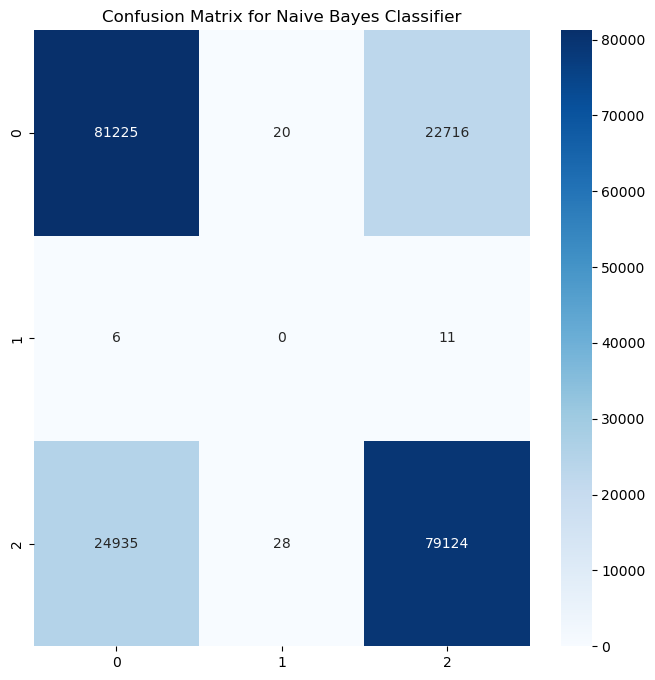

In [15]:
 plt.figure(figsize=(8,8))
sb.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix for Naive Bayes Classifier")

### Predict on test

In [19]:
y_pred_test = model_NB_M.predict(x_c_test)

In [20]:
y_pred_test

array([0, 2, 0, ..., 0, 2, 2])

In [21]:
predictions_df = pd.DataFrame(y_pred_test, columns=['target'])
predictions_df.index.name = 'id'

In [22]:
predictions_df

,target
id,
0,0
1,2
2,0
3,0
4,0
...,...
560170,0
560171,0
560172,0


In [23]:
path_output = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\Test_output\\test_results_MNB.csv'

In [24]:
predictions_df.to_csv(path_output, index=True, index_label='id')

## References

- https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html
- https://www.machinelearningplus.com/nlp/lemmatization-examples-python/